# Risk-Loss: Scientific Trading Risk Analysis

**Risk-Loss** is a modular, research-grade framework for processing and analyzing real trading activity. It supports structured ingestion of execution logs, trade integrity checks, and generation of risk metrics under controlled assumptions.

* 1. [Project Layout](#project-layout)
* 2. []()

--- 

## Project Layout

```
./
‚îú‚îÄ‚îÄ pyproject.toml
‚îú‚îÄ‚îÄ README.md
‚îú‚îÄ‚îÄ notebooks/
‚îú‚îÄ‚îÄ input/                  # Drop .xlsx files here
‚îú‚îÄ‚îÄ output/                 # CSVs, plots, reports
‚îú‚îÄ‚îÄ src/
‚îÇ   ‚îî‚îÄ‚îÄ core/
‚îÇ       ‚îú‚îÄ‚îÄ pipeline.py     # Load & parse new trades
‚îÇ       ‚îú‚îÄ‚îÄ qa.py           # Integrity validation
‚îÇ       ‚îú‚îÄ‚îÄ summary.py      # Daily/global risk metrics
‚îÇ       ‚îú‚îÄ‚îÄ capital.py      # Capital acquisition logic
‚îÇ       ‚îî‚îÄ‚îÄ cli.py          # Command-line interface
‚îî‚îÄ‚îÄ tests/
```

## Installation (editable mode)

```bash
cd ./
pip install -e .
```

## Command-Line Usage

```bash
python src/core/cli.py load --merge --capital 15000
```

Arguments:

* `--merge`: merge fragmented trades
* `--capital`: initial capital (optional; will prompt if missing)

## Processing Pipeline

* Loads new `.xlsx` files from `/input`
* Applies `check_integrity()` to validate structure
* (Optional) Merges split trades
* Computes cumulative equity using initial capital
* Persistence in `output/` as `trades_hist.csv`.
* Additional saving in database (PostgreSQL).
* Prints:

  * Total trades
  * Win-rate
  * Profit Factor
  * Max Drawdown
  * Total PnL
  * Final Equity

## Development Goals

* Add persistent state tracking via SQLite
* Extend CLI with `summary`, `check` subcommands
* Integrate Streamlit for web-based exploration
* Publish as Python package (`risk-loss`)

---

Author: Alex Just Rodr√≠guez
Contact: [alexjustdata@gmail.com](mailto:alexjustdata@gmail.com)


In [2]:
# Paso 1: cargar y preparar el DataFrame desde disco
from core.utils import load_and_prepare_df
df = load_and_prepare_df()  # merge=True, verbose=True por defecto

INFO: üì¶ Total trades cargados: 72
INFO: üíæ Datos guardados en PostgreSQL (trades).
INFO: ‚úÖ Procesados 62 trades en total.


‚úÖ All integrity checks passed
INFO: üóì Fecha primer trade: 2025-06-09
INFO: üíµ Capital inicial de la sesi√≥n: 419.00$
INFO: üìà PnL neto del archivo actual: +495.75$
INFO: üí∞ Equity final tras cargar: 914.75$


In [5]:
# Importa las funciones necesarias desde el m√≥dulo core
from core import daily_summary_from_hist  


# M√©tricas globales r√°pidas
df_summary = daily_summary_from_hist(df)

total_fragmented = df["components"].apply(len).gt(1).sum() if "components" in df.columns else 0

print("\nTrades totales :", len(df))
print(f"N√∫mero de trades fragmentados: {total_fragmented}")
print("Win-rate       :", (df['pnl_net'] > 0).mean())
print("Profit factor  :", df.loc[df['pnl_net'] > 0, 'pnl_net'].sum() /
                          df.loc[df['pnl_net'] < 0, 'pnl_net'].abs().sum())
print("Drawdown m√°x % :", 1 - df['equity'].div(df['equity'].cummax()).min())
print("Total PnL_net   :", df['pnl_net'].sum())
print("√öltima equity   :", df['equity'].iloc[-1])


Trades totales : 58
N√∫mero de trades fragmentados: 3
Win-rate       : 0.5862068965517241
Profit factor  : 1.7122844827586208
Drawdown m√°x % : 0.3617430310797821
Total PnL_net   : 495.75
√öltima equity   : 914.75


In [6]:
import pandas as pd
from core.merger import explain_fragmented_trade

# Ejemplo para un d√≠a concreto con trades fragmentados `fragments_ids`
ids_dia = df_summary.loc[df_summary.day == pd.to_datetime("2025-06-09").date(), "fragmented_ids"].iat[0]

for tid in ids_dia:                     # recorre cada trade-id fragmentado
    for line in explain_fragmented_trade(df, trade_id=tid):
        print(line)
    print()  

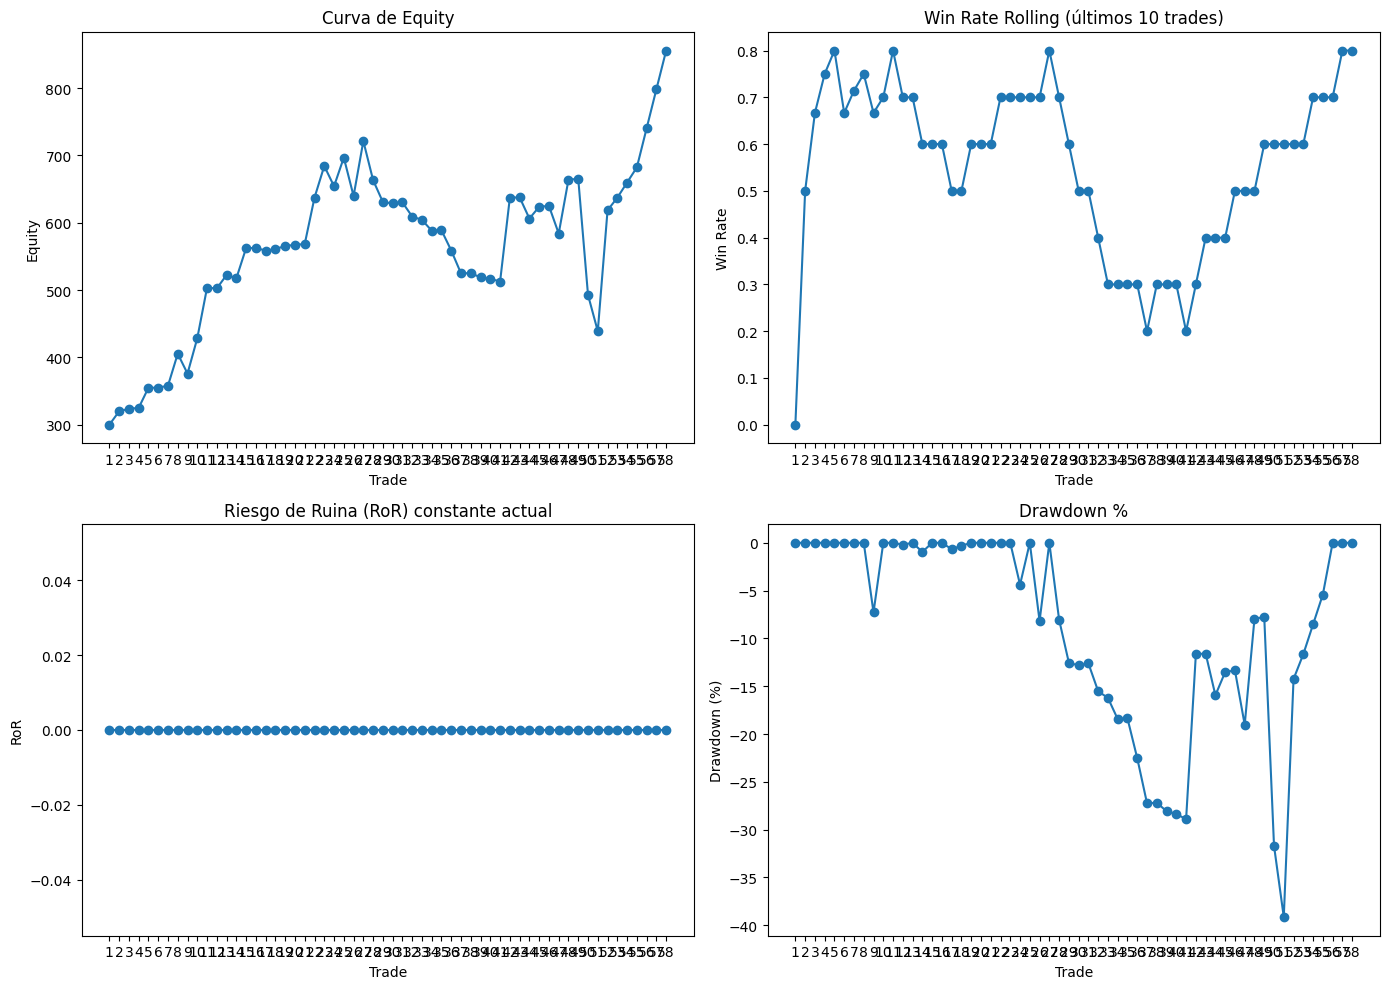

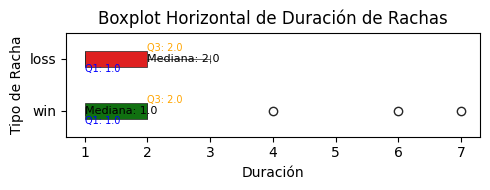


üìà Promedios de Rachas
- Duraci√≥n promedio de rachas ganadoras: 2.27
- Duraci√≥n promedio de rachas perdedoras: 1.60



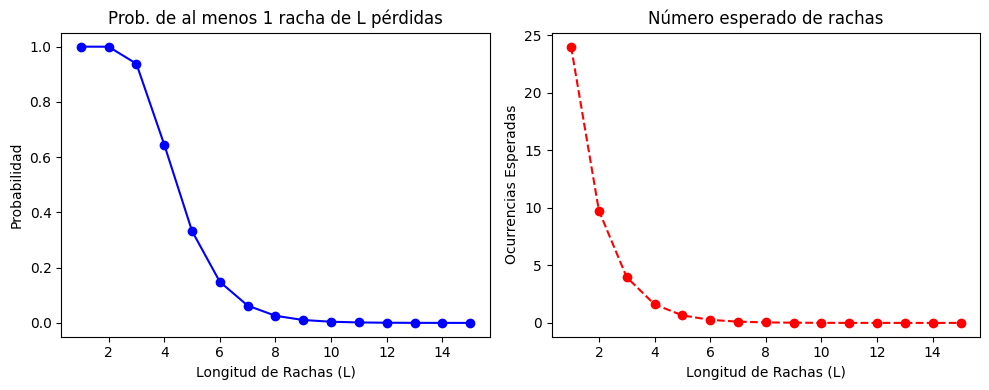


Estad√≠sticas Generales
- Expectancy: 8.55
- Profit Factor: 1.71
- M√°ximo Drawdown: -39.13%
- M√°xima racha de ganancias: 7
- M√°xima racha de p√©rdidas: 3

Intervalo de confianza (95%) para la Expectancy: [-5.87, 21.35]


In [8]:
import importlib, core.statistics
importlib.reload(core.statistics)

from core.statistics import (
    compute_basic_stats,
    print_summary_stats,
    analyze_streaks,
    plot_streak_analysis,
    bootstrap_expectancy_ci
)


# 1. Calcular estad√≠sticas primero
stats = compute_basic_stats(df)

# 2. An√°lisis de rachas
streak_df = analyze_streaks(win_rate=stats['win_rate'], num_trades=len(df))
plot_streak_analysis(streak_df)

# 3. Mostrar resumen
print_summary_stats(stats)

# 4. Intervalo de confianza para la Expectancy
ci_lower, ci_upper = bootstrap_expectancy_ci(df)
print(f"Intervalo de confianza (95%) para la Expectancy: [{ci_lower:.2f}, {ci_upper:.2f}]")